# Here you can try out some queries to find things in a store
This jupyter notebook is based on the shopping assistance scenario. The store depicted in the image below can be used to search for products.

<div>
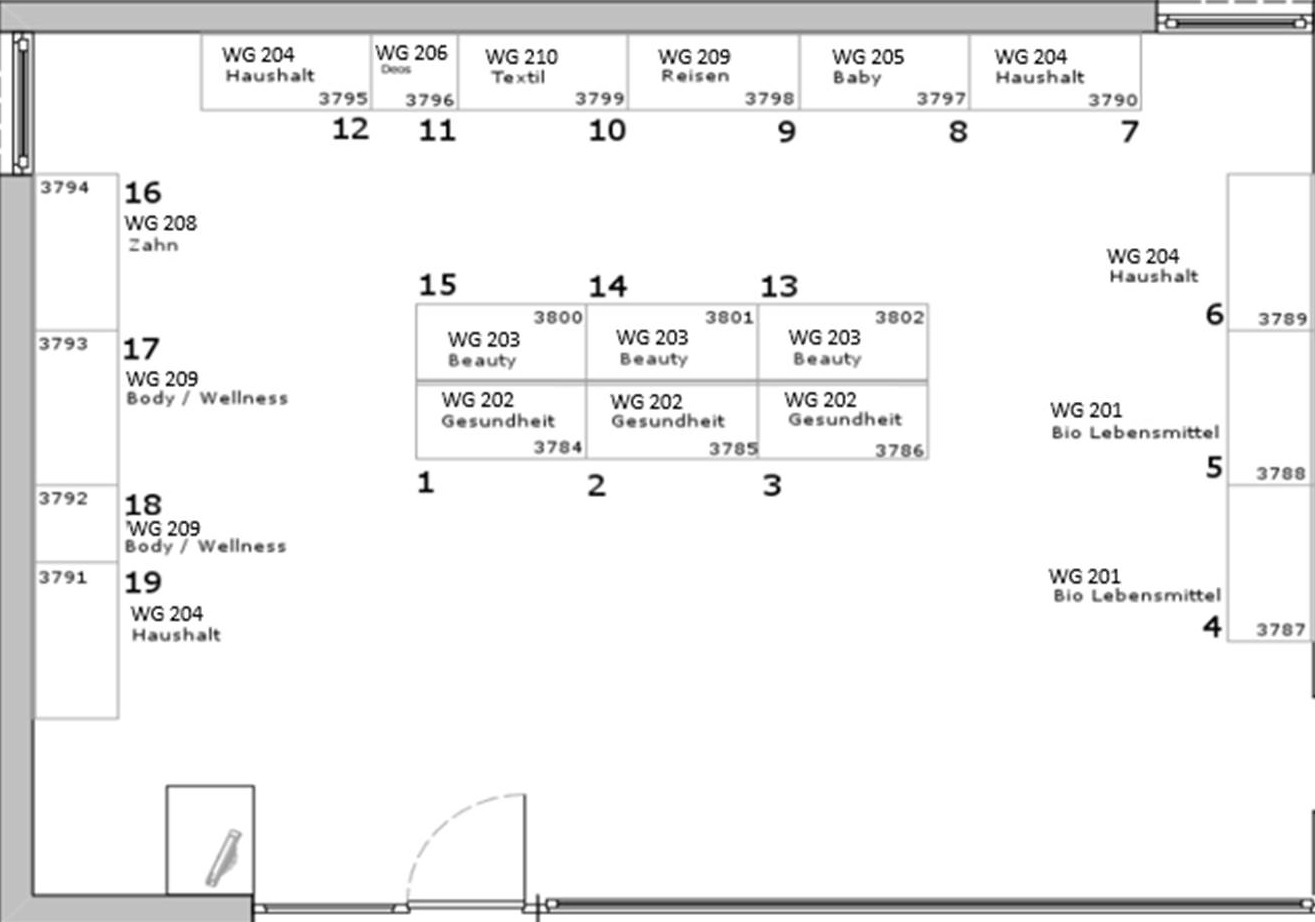
</div>

# First, let us set some parameters for your search!
Run the following code to set the parameters in the dropdown below

In [7]:
import ipywidgets as widgets
from ipywidgets import HBox

# all available parameters
products = [('toothcare',"tax:tooth_care"),
        ('health',"tax:medication"),
        ('well-being',"tax:well-being"),
        ('skincare',"tax:body_care"),
        ('hair care',"tax:hair_care"),
        ('food',"tax:food"),
        ('snacks',"tax:snack"),
        ('babyfood',"tax:baby_food"),
        ('detergent',"tax:detergent"),
        ('pet',"tax:pet"),
        ('travelling',"tax:travel"),
        ('paper products',"tax:paper_products"),
        ('office supply',"tax:school/work")]

preferences=[('vegan',"lbl:vegan"),
      ('no alcohol',"in:Alcohol"),
      ('glutenfree',"lbl:glutenfree"),
      ('environmentally friendly',"lbl:EcoLabel"),
      ('dermatologically tested',"lbl:Dermatologisch_getestet"),
      ('no acids',"in:Acid")]

product=""
pref=""

# Takes a product of the list. 
# Then makes the previously initialized variable global and assigns value of the given product to it 
def chooseProd(Product):
    global product
    product=Product
    
# Takes a preference of the list.
# Then makes the previously initialized variable global and assigns value of the given pref to it 
def choosePref(Pref):
    global pref
    pref=Pref
    
# Create the dropdown widgets
product_widget = widgets.Dropdown(options=products, description='Product:')
pref_widget = widgets.Dropdown(options=preferences, description='Preference:')

# Define the event handlers
def prodEvent(event):
    chooseProd(event.new)

def prefEvent(event):
    choosePref(event.new)
    
# Attach the event handlers to the widgets
product_widget.observe(prodEvent, names='value')
pref_widget.observe(prefEvent, names='value')

# Combine the widgets using HBox
widgets_display = HBox([product_widget, pref_widget])

# Display widgets
widgets_display



## Now we need to import rdflib for querying the knowledge graph
This step is needed to load libraries for execution of the queries

In [2]:
!pip install rdflib
# import rdflib
from rdflib import Graph, Literal, URIRef, Namespace
# rdflib knows about quite a few popular namespaces, like W3C ontologies, schema.org etc
from rdflib.namespace import OWL, RDF, RDFS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 3.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.3 MB/s eta 0:00:00


--------------------------------------------------------------------------------------------------------------------------------
# Let us start with querying the knowledge graph!
## Query 1: Where is the searched product?
Let us first see where the searched product can be found (not including the preference)

In [38]:
g = Graph()

# define prefixes to be used in the query 
TAX = Namespace("http://purl.org/ProductKG/product-taxonomy#")
LOC = Namespace("http://purl.org/ProductKG/location#")
LBL = Namespace("http://purl.org/ProductKG/label#")
BRAND = Namespace("http://purl.org/ProductKG/brandinfo#")
IN = Namespace("http://purl.org/ProductKG/nonfoodingredient#")
GR = Namespace("http://purl.org/goodrelations/v1#")

g.bind("owl", OWL)
g.bind("rdfs", RDFS)
g.bind("tax", TAX)
g.bind("loc", LOC)
g.bind("lbl", LBL)
g.bind("brand", BRAND)
g.bind("in", IN)
g.bind("gr", GR)

# the actual query comes here
query = """SELECT distinct ?shelf WHERE {
      SERVICE <https://api.krr.triply.cc/datasets/mkumpel/ProductKG/services/ProductKG/sparql> {
      ?a rdfs:subclassOf* %s.
      ?product a ?a.
      ?product loc:stored_in ?shelf.} }""" % (product) # the input parameter for the query. For testing, you can remove % (product) here
#and replace %s in the first line of the query with a variable like ?product to get all locations for products

for row in g.query(query):
    print(row.shelf)

http://purl.org/ProductKG/location#Shelf16
http://purl.org/ProductKG/location#Shelf9


## Query 2: Where is the searched product given the preference?
Let us see if the search result is different if we add the preference

In [32]:
twoparametersquery = """SELECT distinct ?shelf WHERE {
      SERVICE <https://api.krr.triply.cc/datasets/mkumpel/ProductKG/services/ProductKG/sparql> {  
  ?s rdfs:subclassOf* %s.
  ?product a ?s.
  {OPTIONAL{?product lbl:has_label %s.
            ?product loc:stored_in ?shelf.}}
  UNION
  {OPTIONAL{?product !in:has_ingredient %s.
            ?product loc:stored_in ?shelf.}}
} }""" % (product,pref,pref) # the input parameter for the query. For testing, you can remove % (tobject) here
#and replace %s in the first line of the query with a variable like ?food to get all food and objects

for row in g.query(twoparametersquery):
    print(row.shelf)

http://purl.org/ProductKG/location#Shelf16
http://purl.org/ProductKG/location#Shelf9


## Query 3: What is the price of the searched product?

In [35]:
pricequery = """SELECT distinct ?price WHERE {
      SERVICE <https://api.krr.triply.cc/datasets/mkumpel/ProductKG/services/ProductKG/sparql> {  
  ?s rdfs:subclassOf* %s.
  ?product a ?s.
  {OPTIONAL{?product lbl:has_label %s.
            ?product loc:has_price ?price.}}
  UNION
  {OPTIONAL{?product !in:has_ingredient %s.
            ?product loc:has_price ?price.}}
} }""" % (product,pref,pref) # the input parameter for the query. For testing, you can remove % (tobject) here
#and replace %s in the first line of the query with a variable like ?food to get all food and objects

for row in g.query(pricequery):
    print(row.price)

6,75
0,55


## Query 4: How many products are on stock?

In [37]:
stockquery = """SELECT distinct ?stock WHERE {
      SERVICE <https://api.krr.triply.cc/datasets/mkumpel/ProductKG/services/ProductKG/sparql> {  
  ?s rdfs:subclassOf* %s.
  ?product a ?s.
  {OPTIONAL{?product lbl:has_label %s.
            ?product loc:has_stock ?stock.}}
  UNION
  {OPTIONAL{?product !in:has_ingredient %s.
            ?product loc:has_stock ?stock.}}
} }""" % (product,pref,pref) # the input parameter for the query. For testing, you can remove % (tobject) here
#and replace %s in the first line of the query with a variable like ?food to get all food and objects

for row in g.query(stockquery):
    print(row.stock)

2
16


## Query 5: What brands are available for this product type?

In [40]:
brandquery = """SELECT distinct ?brand WHERE {
      SERVICE <https://api.krr.triply.cc/datasets/mkumpel/ProductKG/services/ProductKG/sparql> {
      ?a rdfs:subclassOf* %s.
      ?product a ?a.
      ?product gr:hasBrand ?brand.} }""" % (product) # the input parameter for the query. For testing, you can remove % (product) here
#and replace %s in the first line of the query with a variable like ?product to get all locations for products

for row in g.query(brandquery):
    print(row.brand)

http://purl.org/ProductKG/brandinfo#weleda
http://purl.org/ProductKG/brandinfo#dontodent
Dontodent
http://purl.org/ProductKG/brandinfo#onedroponly
http://purl.org/ProductKG/brandinfo#tepe


## Query 6: What labels can this product type have?

In [41]:
lblquery = """SELECT distinct ?label WHERE {
      SERVICE <https://api.krr.triply.cc/datasets/mkumpel/ProductKG/services/ProductKG/sparql> {
      ?a rdfs:subclassOf* %s.
      ?product a ?a.
      ?product lbl:has_label ?label.} }""" % (product) # the input parameter for the query. For testing, you can remove % (product) here
#and replace %s in the first line of the query with a variable like ?product to get all locations for products

for row in g.query(lblquery):
    print(row.label)

http://purl.org/ProductKG/label#Natrue
http://purl.org/ProductKG/label#glutenfree
http://purl.org/ProductKG/label#Der_gruene_Punkt
http://purl.org/ProductKG/label#lactosefree
http://purl.org/ProductKG/label#vegetarian
